In [24]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Toy Pareto Front
## Setup
Given an vector of installed renewable capacities (in MW), $\bm{X}$, the cost and material needs (of steel) are given by the followinig equations.

$$
c=\bm{C}^{T}\bm{X}
$$
$$
m_{steel}=\bm{M_{steel}}^{T}\bm{X}
$$

where
* $c$ is the total scalar cost,
* $m_{steel}$ is the total scaler material need of steel, 
* $C$ is the cost matrix
* $M_{steel}$ is the material need matrix

For this toy energy system to be feasible, it must satisfy the following feasibility function.

$$
f(\bm{X})=\text{CF}^{T}\bm{X} \ge D
$$
where
* $\text{CF}$ is the vector of capacity factors
* $D$ is the average yearly demand in MW

## Defining vectors
This toy example will consider an energy system comprised of only wind and solar PV generation. Therefore, $\bm{X}$ is defined as
$$
\bm{X}=\begin{pmatrix} x_{wind} \\ x_{solar} \end{pmatrix}
$$
The cost is the economic cost per MW of installed capacity, which is USD 1.50/MW for (onshore) wind and USD 1.66/MW for for solar PV (in the USA in 2022)<sup>1</sup>. Therefore the cost vector is
$$
\bm{C} = \begin{pmatrix} c_{wind} \\ c_{solar} \end{pmatrix} = \begin{pmatrix} 1.50 \\ 1.66 \end{pmatrix}
$$
The material steel requirements are 35-45 tons/MW capacity for wind and 120-180 tons/MW for solar (global in 2022)<sup>2</sup>. Therefore, the material requirements vector is
$$
\bm{M_{steel}} = \begin{pmatrix} m_{steel, wind} \\ m_{steel, solar} \end{pmatrix} = \begin{pmatrix} 40 \\ 150 \end{pmatrix}
$$
The capacity factors are 0.3-0.5 for wind and 0.15-0.2 for solar<sup>3</sup>. Therefore, the capacity factor vector is
$$
\text{CF} = \begin{pmatrix} \text{CF}_{wind} \\ \text{CF}_{solar} \end{pmatrix} = \begin{pmatrix} 0.4 \\ 0.175 \end{pmatrix}
$$
The yearly European electricity consumption is approximately 3000 TWh, which is an average of 350 GW. Therefore, the demand (in MW) is
$$
D = 350,000
$$

In [61]:
c_w = 1.5
c_s = 1.66
m_w = 40
m_s = 150
cf_w = 0.4
cf_s = 0.175
D = 350000

class Sample:
    """
    Class for each wind, solar data point input and their respective output quantities.
    """

    # define constants as class-level attributes
    C = np.array([[c_w], [c_s]])  # Cost matrix
    M_steel = np.array([[m_w], [m_s]])  # Material need matrix
    CF = np.array([[cf_w], [cf_s]])  # Capacity factor matrix
    D = D

    def __init__(self, x_wind, x_solar):
        self.x_wind = x_wind
        self.x_solar = x_solar

    @property
    def X(self):
        # Vector representing the two input variables of each output
        return np.array([[self.x_wind], [self.x_solar]])

    @property
    def is_feasible(self):
        return (Sample.CF.T @ self.X >= Sample.D).item()
    
    @property
    def cost(self):
        return (Sample.C.T @ self.X).item()

    @property
    def material_needs_steel(self):
        return (Sample.M_steel.T @ self.X).item()


## Sampling from the input space

Using a Monte Carlo technique, $\bm{X}$ can be sampled from a uniform distribution between arbitrary bounds for the capacites of wind and solar. Here we will choose within 50% of the maximum for wind and solar.

By rearranging the feasibility condition, we can find the maximum capacities of wind and solar, which will be used to set the bounds for sampling.
$$
x_{wind}(x_{solar} = 0) = \frac{D}{\text{CF}_{solar}}, \quad
x_{solar}(x_{wind} = 0) = \frac{D}{\text{CF}_{wind}}
$$

In [62]:
num_samples = 10000
samples = []
x_wind_max = Sample.D / Sample.CF[0, 0]
x_solar_max = Sample.D / Sample.CF[1, 0]
x_wind_range = (0, x_wind_max * 1.5)
x_solar_range = (0, x_solar_max * 1.5)

for _ in range(num_samples):
    samples.append(Sample(np.random.uniform(*x_wind_range), np.random.uniform(*x_solar_range)))

## Plotting the input space

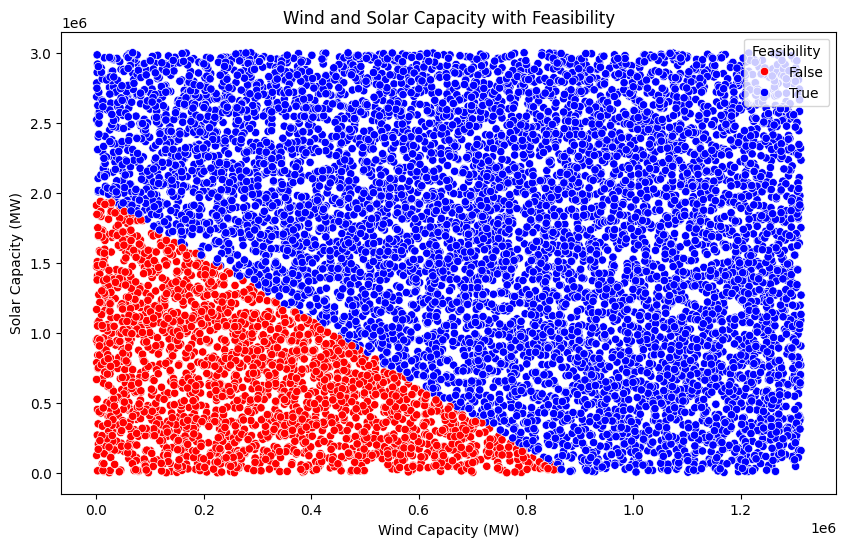

In [63]:
# Convert list of objects into a Pandas DataFrame
x_wind_values = [sample.x_wind for sample in samples]
x_solar_values = [sample.x_solar for sample in samples]
costs = [sample.cost for sample in samples]
material_needs = [sample.material_needs_steel for sample in samples]
feasibility = [sample.is_feasible for sample in samples]

data = pd.DataFrame({
    'Wind Capacity (MW)': x_wind_values,
    'Solar Capacity (MW)': x_solar_values,
    'Cost (USD)': costs,
    'Material Needs (tons)': material_needs,
    'Feasibility': feasibility,
})

# Plot input space
plt.figure(figsize=(10, 6))
sns.scatterplot(data=data, x='Wind Capacity (MW)', y='Solar Capacity (MW)', hue='Feasibility', palette=['red', 'blue'])
plt.title('Wind and Solar Capacity with Feasibility')
plt.show()

## Plotting the Pareto Front of materials requirements against cost

We can plot the cost, $c$, and material requirements of steel, $m_{steel}$, for each feasible point in the input space.

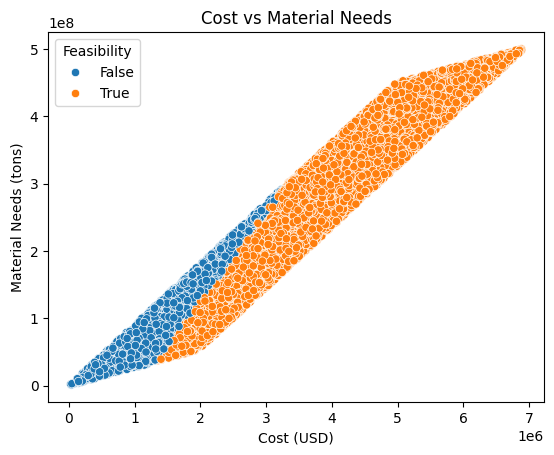

In [64]:
sns.scatterplot(x='Cost (USD)', y='Material Needs (tons)', hue='Feasibility', data=data)
plt.title('Cost vs Material Needs')
plt.show()

Wow, look at that! It's just a linear transformation (a shear or something) of the original input space. This is the point at which I took a break to revise my linear algebra ...



## Linear algebra interpretation

$$
c = \bm{C}^{T}\bm{X},\; m = \bm{M}^{T}\bm{X}
\\[10pt]
\bm{Y} = \begin{pmatrix} c_{wind} && c_{solar} \\ m_{steel, wind} && m_{steel, solar} \end{pmatrix} \bm{X}
$$

Where $\bm{Y}$ is the vector output space, $\bm{Y} =  \begin{pmatrix} c \\ m \end{pmatrix} $

This can be visualised as a linear transformation according to matrix $A = \begin{pmatrix} 1.50 && 1.66 \\ 40 && 150 \end{pmatrix}$. This means the input space is linearly mapped to an output space according to the new basis vectors below:

$$
\bm{\hat{i}}' = \begin{bmatrix} 1.5 \\ 40 \end{bmatrix}, \;
\bm{\hat{j}}' = \begin{bmatrix} 1.66 \\ 150 \end{bmatrix}
$$

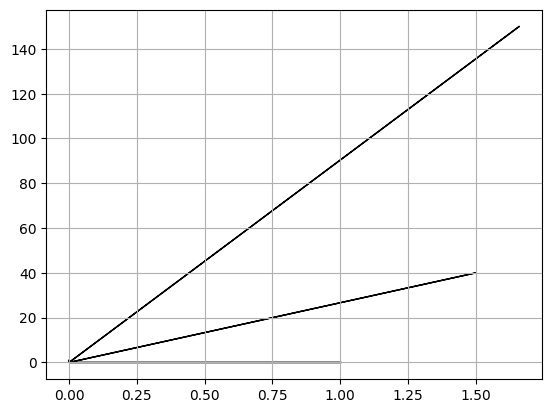

In [67]:
# plot the new basis vectors

# basis vectors
i_hat = np.array([[1], [0]])
j_hat = np.array([[0], [1]])

# transformed basis vectors
i_hat_prime = np.array([[c_w], [m_w]])
j_hat_prime = np.array([[c_s], [m_s]])

vectors = [i_hat, j_hat, i_hat_prime, j_hat_prime]

fig, ax = plt.subplots()

# Plot each vector
for v in vectors:
    ax.arrow(0, 0, v[0, 0], v[1, 0], length_includes_head=False)

ax.grid(True)

plt.show()

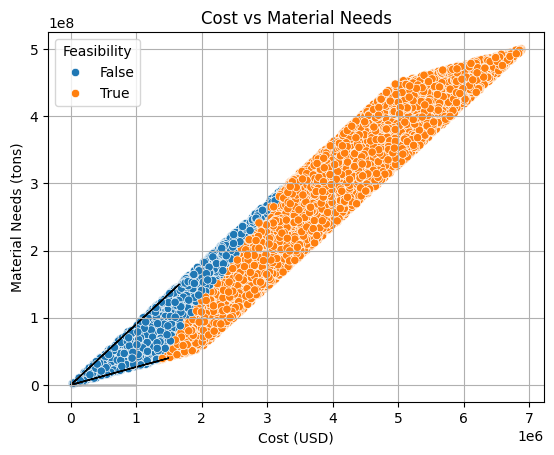

In [68]:
# integrate the new basis vectors into the above seaborn plot

ax = sns.scatterplot(x='Cost (USD)', y='Material Needs (tons)', hue='Feasibility', data=data)
plt.title('Cost vs Material Needs')

# Plot each vector
for v in vectors:
    v = v * 1e6 # scale vectors up so they're visible
    ax.arrow(0, 0, v[0, 0], v[1, 0])

ax.grid(True)

plt.show()

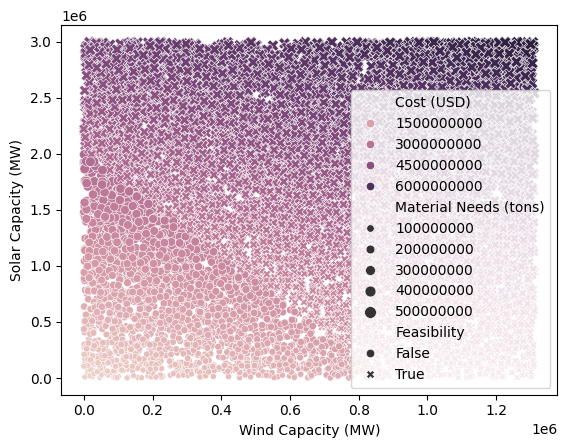

In [30]:
sns.scatterplot(x='Wind Capacity (MW)', y='Solar Capacity (MW)', style='Feasibility', hue='Cost (USD)', size='Material Needs (tons)', data=data)

plt.show()



# References
1. https://www.eia.gov/todayinenergy/detail.php?id=54519 
2. https://cleantechnica.com/2023/03/27/how-much-steel-will-all-those-wind-turbines-solar-panels-need-can-we-make-it/#:~:text=Each%20new%20MW%20of%20solar,to%20180%20tons%20of%20steel
3. https://www.nrel.gov/docs/fy15osti/63038.pdf